In [1]:
import tensorflow as tf  # وارد کردن کتابخانه TensorFlow برای استفاده از قابلیت‌های یادگیری عمیق
from tensorflow.keras.datasets import fashion_mnist  # وارد کردن دیتاست Fashion MNIST برای استفاده در آموزش مدل
from tensorflow.keras import layers, models, regularizers  # وارد کردن ماژول‌های مختلف برای ساخت مدل و لایه‌ها
import matplotlib.pyplot as plt  # وارد کردن کتابخانه Matplotlib برای رسم نمودارها
import numpy as np  # وارد کردن کتابخانه NumPy برای انجام محاسبات عددی
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score  # وارد کردن متریک‌های ارزیابی مدل
import seaborn as sns  # وارد کردن کتابخانه Seaborn برای رسم نمودارهای زیبا و تحلیل داده‌ها

In [2]:
# بارگذاری دیتاست Fashion MNIST
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# نمایش شکل داده‌های آموزشی
print("Training Data Shape:", train_images.shape)  # نمایش ابعاد تصاویر آموزشی
print("Testing Data Shape:", test_images.shape)    # نمایش ابعاد تصاویر آزمایشی

# نرمال‌سازی تصاویر از بازه [0, 255] به [0.0, 1.0]
train_data_clean = train_images / 255.0  # تقسیم تصاویر آموزشی بر 255 برای نرمال‌سازی
test_data_clean = test_images / 255.0    # تقسیم تصاویر آزمایشی بر 255 برای نرمال‌سازی

# نمایش برچسب‌های منحصر به فرد در داده‌های آموزشی و آزمایشی
print("Unique Train Labels:", np.unique(train_labels))  # نمایش برچسب‌های منحصر به فرد در داده‌های آموزشی
print("Unique Test Labels:", np.unique(test_labels))    # نمایش برچسب‌های منحصر به فرد در داده‌های آزمایشی

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training Data Shape: (60000, 28, 28)
Testing Data Shape: (10000, 28, 28)
Unique Train Labels: [0 1 2 3 4 5 6 7 8 9]
Unique Test Labels: [0 1 2 3 4 5 6 7 8 9]


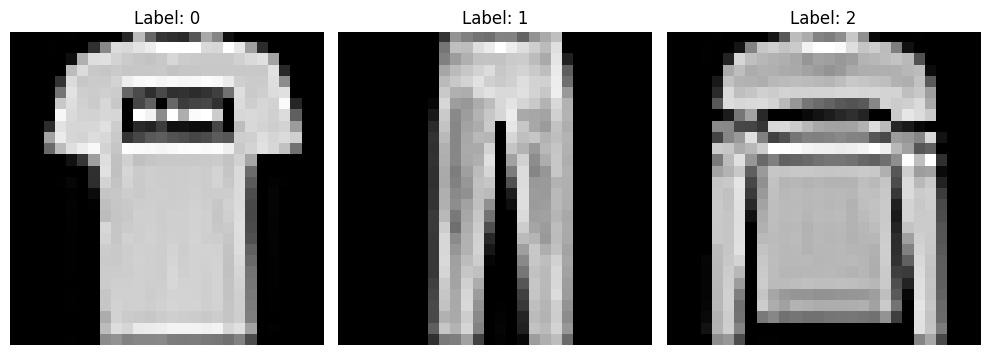

In [3]:
# تابعی برای نمایش تصاویر نمونه
def display_images(images, labels, num_images=3):
    selected_classes = [0, 1, 2]  # انتخاب کلاس‌های خاص برای نمایش

    # لیست‌های خالی برای ذخیره تصاویر و برچسب‌ها
    selected_images = []
    selected_labels = []

    # انتخاب یک تصویر از هر کلاس انتخاب شده
    for class_label in selected_classes:
        class_indices = np.where(labels == class_label)[0]  # پیدا کردن ایندکس‌های تصاویر مربوط به کلاس
        selected_images.append(images[class_indices[0]])  # انتخاب اولین تصویر از کلاس
        selected_labels.append(labels[class_indices[0]])  # ذخیره برچسب مربوطه

    # تبدیل لیست‌ها به آرایه
    selected_images = np.array(selected_images)
    selected_labels = np.array(selected_labels)

    # ایجاد یک شکل برای نمایش تصاویر
    fig, axes = plt.subplots(1, num_images, figsize=(10, 4))  # ایجاد زیرنمودارها
    for i, ax in enumerate(axes):
        ax.imshow(selected_images[i].squeeze(), cmap='gray')  # حذف بعد کانال و نمایش تصویر
        ax.set_title(f'Label: {selected_labels[i]}')  # نمایش برچسب زیر تصویر
        ax.axis('off')  # مخفی کردن محورهای نمودار
    plt.tight_layout()  # تنظیم فضای بین زیرنمودارها
    plt.show()  # نمایش تصاویر

# نمایش داده‌های نمونه از دیتاست تمیز شده
display_images(train_data_clean, train_labels, num_images=3)  # فراخوانی تابع برای نمایش سه تصویر نمونه

Noisy Training Data Shape: (60000, 28, 28)
Noisy Testing Data Shape: (60000, 28, 28)


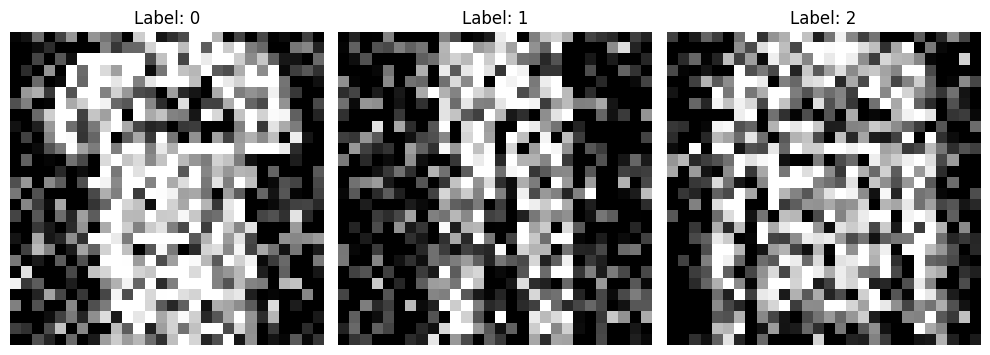

In [4]:
# تابعی برای افزودن نویز گوسی به تصاویر
def add_gaussian_noise(images, mean=0.0, severity=1):
    severity_levels = [0.08, 0.12, 0.18, 0.26, 0.38]  # سطوح شدت نویز
    stddev = severity_levels[severity - 1]  # دریافت انحراف معیار بر اساس شدت
    noise = np.random.normal(mean, stddev, images.shape)  # تولید نویز گوسی
    noisy_images = images + noise  # افزودن نویز به تصاویر
    noisy_images = np.clip(noisy_images, 0.0, 1.0)  # اطمینان از اینکه مقادیر پیکسل‌ها در بازه [0.0, 1.0] هستند
    return noisy_images  # بازگرداندن تصاویر با نویز

# افزودن نویز به داده‌های آموزشی و آزمایشی
train_data_noisy = add_gaussian_noise(train_data_clean, severity=5)  # افزودن نویز به داده‌های آموزشی
test_data_noisy = add_gaussian_noise(test_data_clean, severity=5)    # افزودن نویز به داده‌های آزمایشی

# نمایش شکل داده‌های آموزشی و آزمایشی با نویز
print("Noisy Training Data Shape:", train_data_noisy.shape)  # نمایش ابعاد داده‌های آموزشی با نویز
print("Noisy Testing Data Shape:", train_data_noisy.shape)    # نمایش ابعاد داده‌های آزمایشی با نویز

# نمایش تصاویر نمونه با نویز
display_images(train_data_noisy, train_labels, num_images=3)  # فراخوانی تابع برای نمایش سه تصویر نمونه با نویز

In [5]:
# تابعی برای ایجاد مدل CCNN برای تصاویر با اندازه کامل
def create_model():
    model = models.Sequential()  # ایجاد یک مدل ترتیبی

    # بلوک ۱
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))  # لایه کانولوشن با 32 فیلتر و اندازه (3x3)
    model.add(layers.BatchNormalization())  # نرمال‌سازی بچ
    model.add(layers.MaxPooling2D((2, 2), strides=2))  # لایه ماکس پولینگ برای کاهش ابعاد
    model.add(tf.keras.layers.Dropout(0.5))  # لایه دراپ‌اوت برای جلوگیری از بیش‌برازش

    # بلوک ۲
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))  # لایه کانولوشن با 64 فیلتر
    model.add(layers.BatchNormalization())  # نرمال‌سازی بچ

    # بلوک ۳
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))  # لایه کانولوشن با 64 فیلتر
    model.add(layers.BatchNormalization())  # نرمال‌سازی بچ

    # لایه‌های Flatten و Dense
    model.add(layers.Flatten())  # صاف کردن خروجی لایه‌های قبلی
    model.add(layers.Dense(128, activation='relu'))  # لایه Dense با 128 نورون
    model.add(tf.keras.layers.Dropout(0.5))  # لایه دراپ‌اوت
    model.add(layers.Dense(10, activation='softmax'))  # لایه خروجی با 10 کلاس برای دیتاست Fashion MNIST

    model.summary()  # نمایش خلاصه‌ای از ساختار مدل

    # کامپایل مدل
    model.compile(optimizer='adam',  # انتخاب بهینه‌ساز
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # تابع هزینه
                  metrics=['accuracy'])  # معیار دقت

    return model  # بازگشت مدل ایجاد شده

In [6]:
# ایجاد مدل تمیز برای دیتاست تمیز
clean_model = create_model()  # فراخوانی تابع برای ایجاد مدل

# آموزش مدل با داده‌های تمیز
history_clean = clean_model.fit(train_data_clean,  # داده‌های آموزشی
                                 train_labels,  # برچسب‌های آموزشی
                                 epochs=10,  # تعداد دوره‌های آموزش
                                 batch_size=128,  # اندازه بچ
                                 validation_data=(test_data_clean, test_labels)  # داده‌های اعتبارسنجی
                                )

# ارزیابی بر روی داده‌های آزمایشی تمیز
test_loss_clean, test_acc_clean = clean_model.evaluate(test_data_clean, test_labels, verbose=2)  # ارزیابی مدل
print(f"Clean Data - Test Accuracy: {test_acc_clean:.4f}, Test Loss: {test_loss_clean:.4f}")  # نمایش دقت و خسارت تست
print(f"Clean Data - Training Accuracy: {history_clean.history['accuracy'][-1]:.4f}")  # نمایش دقت آموزش

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 9, 9, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 9, 9, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5184)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       663,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 721,354 (2.75 MB)

 Trainable params: 721,034 (2.75 MB)

 Non-trainable params: 320 (1.25 KB)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 121s 249ms/step - accuracy: 0.7325 - loss: 0.7961 - val_accuracy: 0.7905 - val_loss: 0.6153
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 147s 260ms/step - accuracy: 0.8553 - loss: 0.4026 - val_accuracy: 0.8869 - val_loss: 0.3234
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 118s 252ms/step - accuracy: 0.8731 - loss: 0.3501 - val_accuracy: 0.8935 - val_loss: 0.3070
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 144s 257ms/step - accuracy: 0.8885 - loss: 0.3059 - val_accuracy: 0.9010 - val_loss: 0.2800
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 133s 284ms/step - accuracy: 0.8989 - loss: 0.2790 - val_accuracy: 0.8855 - val_loss: 0.3417
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 124s 246ms/step - accuracy: 0.9055 - loss: 0.2647 - val_accuracy: 0.8930 - val_loss: 0.2869
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 151s 266ms/step - accuracy: 0.9080 - loss: 0.2453 - val_accuracy: 0.9126 - val_loss: 0.2505
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 131s 243ms/step - accuracy: 0.9145 -

In [7]:
# تابعی برای نمایش منحنی‌های آموزش و اعتبارسنجی
def plot_metrics(history, metric_name, title, ylim=1, xlim=10):
    plt.title(title)  # عنوان نمودار
    plt.ylim(0, ylim)  # تنظیم حدود محور Y
    plt.xlim(0, xlim)  # تنظیم حدود محور X
    plt.plot(history.history[metric_name], color='blue', label='Train')  # رسم منحنی دقت آموزش
    plt.plot(history.history['val_' + metric_name], color='green', label='Validation')  # رسم منحنی دقت اعتبارسنجی
    plt.legend(loc='lower right')  # قرار دادن افسانه در گوشه پایین راست
    plt.xlabel("Epoch")  # برچسب محور X
    plt.ylabel("Accuracy")  # برچسب محور Y

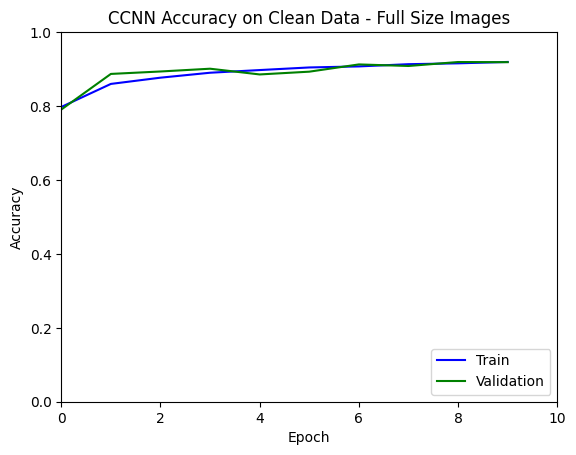

In [8]:
plot_metrics(history_clean, "accuracy", "CCNN Accuracy on Clean Data - Full Size Images")

In [9]:
# ایجاد مدل دیگری برای دیتاست نویزی
noisy_model = create_model()  # فراخوانی تابع برای ایجاد مدل

# آموزش مدل با داده‌های نویزی
history_noisy = noisy_model.fit(train_data_noisy,  # داده‌های آموزشی نویزی
                                 train_labels,  # برچسب‌های آموزشی
                                 epochs=10,  # تعداد دوره‌های آموزش
                                 batch_size=128,  # اندازه بچ
                                 validation_data=(test_data_noisy, test_labels)  # داده‌های اعتبارسنجی نویزی
                                )

# ارزیابی بر روی داده‌های آزمایشی نویزی
test_loss_noisy, test_acc_noisy = noisy_model.evaluate(test_data_noisy, test_labels, verbose=2)  # ارزیابی مدل
print(f"Noisy Data - Test Accuracy: {test_acc_noisy:.4f}, Test Loss: {test_loss_noisy:.4f}")  # نمایش دقت و خسارت تست
print(f"Noisy Data - Training Accuracy: {history_noisy.history['accuracy'][-1]:.4f}")  # نمایش دقت آموزش

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 9, 9, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 9, 9, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 5184)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       663,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 721,354 (2.75 MB)

 Trainable params: 721,034 (2.75 MB)

 Non-trainable params: 320 (1.25 KB)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 113s 235ms/step - accuracy: 0.6352 - loss: 1.0912 - val_accuracy: 0.7182 - val_loss: 0.7442
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 235ms/step - accuracy: 0.7716 - loss: 0.6067 - val_accuracy: 0.8116 - val_loss: 0.5153
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 135s 220ms/step - accuracy: 0.7948 - loss: 0.5492 - val_accuracy: 0.8259 - val_loss: 0.4750
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 106s 225ms/step - accuracy: 0.8141 - loss: 0.4987 - val_accuracy: 0.8203 - val_loss: 0.4743
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 140s 221ms/step - accuracy: 0.8261 - loss: 0.4669 - val_accuracy: 0.8247 - val_loss: 0.4743
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 105s 225ms/step - accuracy: 0.8293 - loss: 0.4507 - val_accuracy: 0.8371 - val_loss: 0.4470
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 140s 220ms/step - accuracy: 0.8388 - loss: 0.4251 - val_accuracy: 0.8357 - val_loss: 0.4592
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 143s 221ms/step - accuracy: 0.8415 -

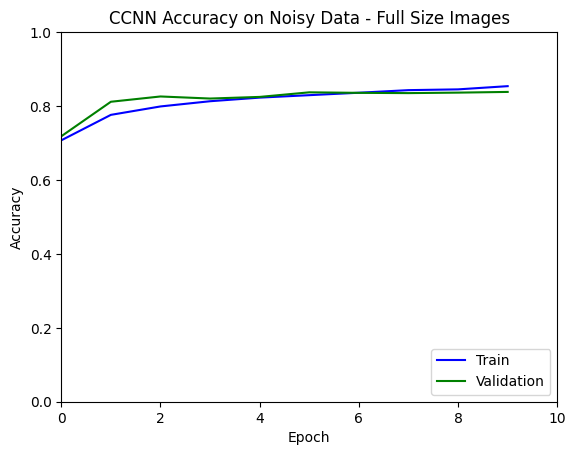

In [10]:
# رسم منحنی دقت مدل بر روی داده‌های نویزی
plot_metrics(history_noisy, "accuracy", "CCNN Accuracy on Noisy Data - Full Size Images")

In [11]:
# استخراج برچسب‌های واقعی برای سایر متریک‌های عملکرد
y_true = test_labels  # برچسب‌های واقعی داده‌های آزمایشی

# پیش‌بینی‌های مدل تمیز
y_pred_clean = clean_model.predict(test_data_clean)  # پیش‌بینی برچسب‌ها برای داده‌های آزمایشی تمیز
y_pred_clean = np.argmax(y_pred_clean, axis=-1)  # تبدیل احتمال‌ها به ایندکس‌های کلاس

# پیش‌بینی‌های مدل نویزی
y_pred_noisy = noisy_model.predict(test_data_noisy)  # پیش‌بینی برچسب‌ها برای داده‌های آزمایشی نویزی
y_pred_noisy = np.argmax(y_pred_noisy, axis=-1)  # تبدیل احتمال‌ها به ایندکس‌های کلاس

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step


In [12]:
# محاسبه متریک‌های مدل تمیز
accuracy_clean = accuracy_score(y_true, y_pred_clean)  # محاسبه دقت
precision_clean = precision_score(y_true, y_pred_clean, average='weighted')  # محاسبه دقت وزنی
recall_clean = recall_score(y_true, y_pred_clean, average='weighted')  # محاسبه فراخوان وزنی
f1_clean = f1_score(y_true, y_pred_clean, average='weighted')  # محاسبه امتیاز F1 وزنی

# نمایش متریک‌ها
print("\nClean Data Metrics:")
print(f"Accuracy: {accuracy_clean:.4f}")  # نمایش دقت
print(f"Precision: {precision_clean:.4f}")  # نمایش دقت
print(f"Recall: {recall_clean:.4f}")  # نمایش فراخوان
print(f"F1 Score: {f1_clean:.4f}")  # نمایش امتیاز F1


Clean Data Metrics:
Accuracy: 0.9187
Precision: 0.9195
Recall: 0.9187
F1 Score: 0.9187


In [13]:
# محاسبه متریک‌های مدل نویزی
accuracy_noisy = accuracy_score(y_true, y_pred_noisy)  # محاسبه دقت
precision_noisy = precision_score(y_true, y_pred_noisy, average='weighted')  # محاسبه دقت وزنی
recall_noisy = recall_score(y_true, y_pred_noisy, average='weighted')  # محاسبه فراخوان وزنی
f1_noisy = f1_score(y_true, y_pred_noisy, average='weighted')  # محاسبه امتیاز F1 وزنی

# نمایش متریک‌ها
print("\nNoisy Data Metrics:")
print(f"Accuracy: {accuracy_noisy:.4f}")  # نمایش دقت
print(f"Precision: {precision_noisy:.4f}")  # نمایش دقت
print(f"Recall: {recall_noisy:.4f}")  # نمایش فراخوان
print(f"F1 Score: {f1_noisy:.4f}")  # نمایش امتیاز F1


Noisy Data Metrics:
Accuracy: 0.8382
Precision: 0.8381
Recall: 0.8382
F1 Score: 0.8364


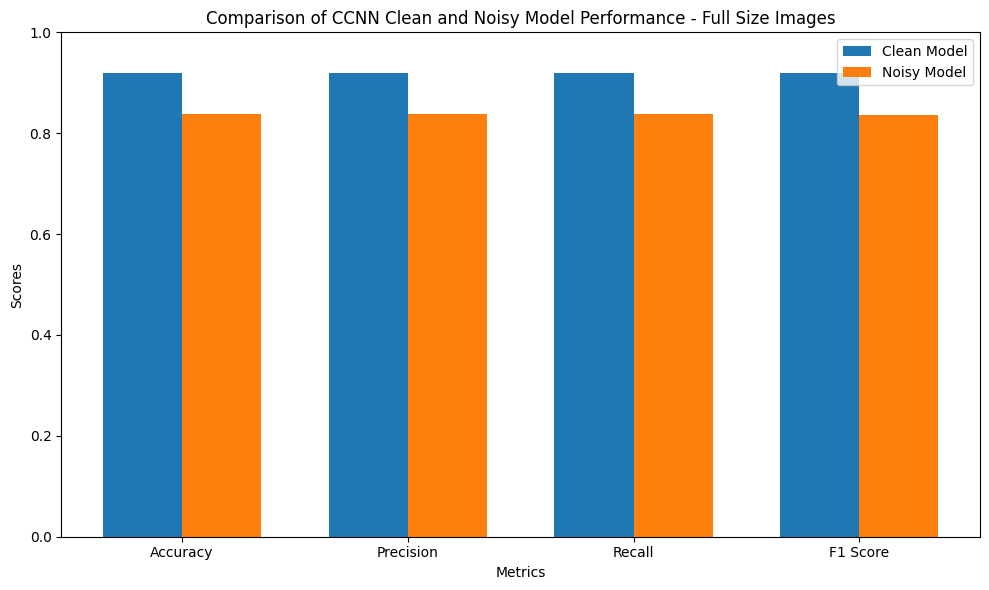

In [14]:
# تعریف متریک‌ها و مقادیر مربوطه
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']  # نام متریک‌ها
clean_values = [accuracy_clean, precision_clean, recall_clean, f1_clean]  # مقادیر متریک‌های مدل تمیز
noisy_values = [accuracy_noisy, precision_noisy, recall_noisy, f1_noisy]  # مقادیر متریک‌های مدل نویزی

# تنظیمات برای رسم نمودار
x = np.arange(len(metrics))  # مکان برچسب‌ها
width = 0.35  # عرض میله‌ها
fig, ax = plt.subplots(figsize=(10, 6))  # ایجاد شکل و محور

# رسم میله‌های مدل تمیز و نویزی
rects1 = ax.bar(x - width/2, clean_values, width, label='Clean Model')  # میله‌های مدل تمیز
rects2 = ax.bar(x + width/2, noisy_values, width, label='Noisy Model')  # میله‌های مدل نویزی

# تنظیمات محور و عنوان
ax.set_xlabel('Metrics')  # برچسب محور X
ax.set_ylabel('Scores')  # برچسب محور Y
ax.set_title('Comparison of CCNN Clean and Noisy Model Performance - Full Size Images')  # عنوان نمودار
ax.set_xticks(x)  # تنظیم برچسب‌های محور X
ax.set_xticklabels(metrics)  # برچسب‌های متریک‌ها
ax.legend()  # نمایش افسانه
ax.set_ylim(0, 1)  # محدوده ثابت محور Y از 0 تا 1

# نمایش نمودار
plt.tight_layout()  # تنظیمات نهایی
plt.show()  # نمایش نمودار



---
In the next section we perform multiclass classification on images that are scaled down to 4x4 pixels to show a fair comparison with the image sizes provided to the QCNN. Subsets of the data are also taken in the same random sampling method used in the QCNN.


---




In [15]:
# تعداد نمونه‌هایی که در زیرمجموعه‌ها خواهد بود،
# حفظ نسبت اصلی 6:1 از داده‌های آموزشی به آزمایشی
num_train = 6000  # تعداد کل نمونه‌های آموزشی
num_test = 1000   # تعداد کل نمونه‌های آزمایشی

# تعداد نمونه‌ها در هر کلاس (10 کلاس)
num_train_per_class = num_train // 10  # تعداد نمونه‌های آموزشی در هر کلاس
num_test_per_class = num_test // 10      # تعداد نمونه‌های آزمایشی در هر کلاس

# لیست‌هایی برای ذخیره زیرمجموعه‌های تصاویر و برچسب‌ها
train_images_subset = []
train_labels_subset = []
test_images_subset = []
test_labels_subset = []

# تکرار بر روی هر کلاس و نمونه‌گیری به طور مساوی
for i in range(10):
    class_indices_train = np.where(train_labels == i)[0]  # ایندکس‌های کلاس در داده‌های آموزشی
    class_indices_test = np.where(test_labels == i)[0]    # ایندکس‌های کلاس در داده‌های آزمایشی

    # نمونه‌گیری تصادفی از تصاویر در هر کلاس
    sampled_train_indices = np.random.choice(class_indices_train, num_train_per_class, replace=False)  # ایندکس‌های نمونه‌های آموزشی
    sampled_test_indices = np.random.choice(class_indices_test, num_test_per_class, replace=False)      # ایندکس‌های نمونه‌های آزمایشی

    # اضافه کردن آن‌ها به لیست
    train_images_subset.append(train_data_clean[sampled_train_indices])  # تصاویر آموزشی نمونه‌گیری شده
    train_labels_subset.append(train_labels[sampled_train_indices])      # برچسب‌های آموزشی نمونه‌گیری شده
    test_images_subset.append(test_data_clean[sampled_test_indices])    # تصاویر آزمایشی نمونه‌گیری شده
    test_labels_subset.append(test_labels[sampled_test_indices])        # برچسب‌های آزمایشی نمونه‌گیری شده

# تبدیل لیست‌ها به آرایه‌ها
train_images_subset = np.concatenate(train_images_subset)  # ادغام تصاویر آموزشی
train_labels_subset = np.concatenate(train_labels_subset)    # ادغام برچسب‌های آموزشی
test_images_subset = np.concatenate(test_images_subset)      # ادغام تصاویر آزمایشی
test_labels_subset = np.concatenate(test_labels_subset)      # ادغام برچسب‌های آزمایشی

# نمایش شکل داده‌های آموزشی و آزمایشی
print("Training Data Shape (After Subset):", train_images_subset.shape)  # نمایش شکل داده‌های آموزشی
print("Testing Data Shape (After Subset):", test_images_subset.shape)    # نمایش شکل داده‌های آزمایشی

# چاپ کلاس‌های منحصر به فرد برای تأیید اینکه همه 10 کلاس شامل شده‌اند
print("Unique Train Labels:", np.unique(train_labels))  # کلاس‌های منحصر به فرد در داده‌های آموزشی
print("Unique Test Labels:", np.unique(test_labels))    # کلاس‌های منحصر به فرد در داده‌های آزمایشی

Training Data Shape (After Subset): (6000, 28, 28)
Testing Data Shape (After Subset): (1000, 28, 28)
Unique Train Labels: [0 1 2 3 4 5 6 7 8 9]
Unique Test Labels: [0 1 2 3 4 5 6 7 8 9]


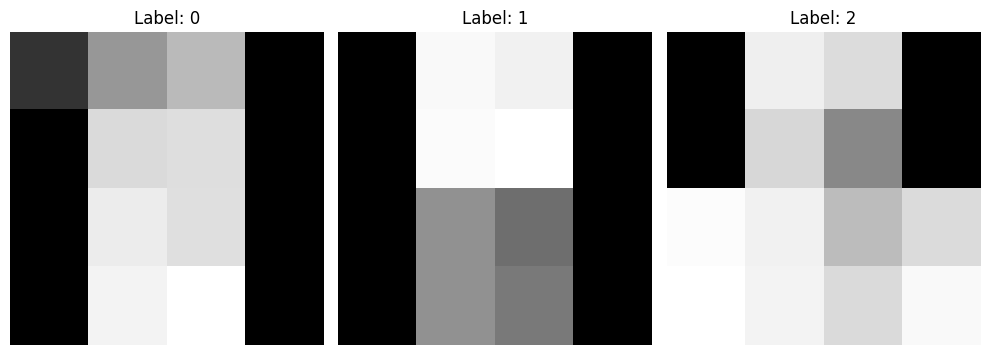

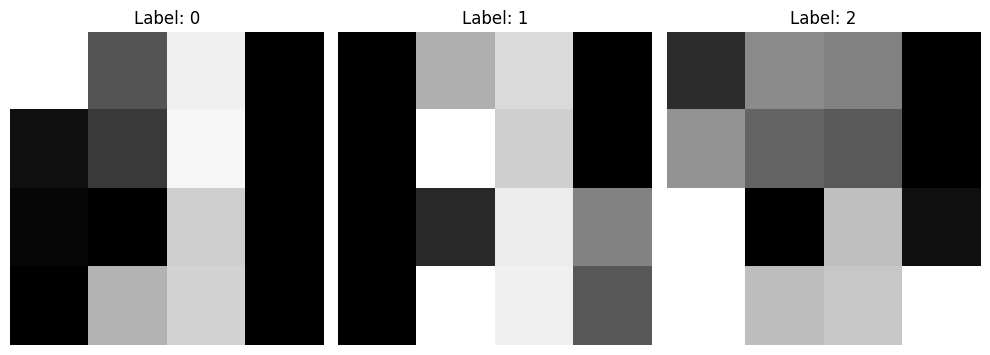

In [16]:
# Create new resized input images
def resize_images_tf(images, new_size=(4, 4)):
    images = tf.expand_dims(images, axis=-1)  # Add the channel dimension (1 for grayscale)
    resized_images = tf.image.resize(images, new_size)
    return resized_images

# Resize and show the clean and noisy 4x4 images
train_data_clean_4x4 = resize_images_tf(train_images_subset, new_size=(4, 4))
test_data_clean_4x4 = resize_images_tf(test_images_subset, new_size=(4, 4))
display_images(train_data_clean_4x4, train_labels_subset, num_images=3)

train_data_noisy_4x4 = add_gaussian_noise(train_data_clean_4x4, severity=5)
test_data_noisy_4x4 = add_gaussian_noise(test_data_clean_4x4, severity=5)
display_images(train_data_noisy_4x4, train_labels_subset, num_images=3)

In [17]:
# تابعی برای ایجاد مدل CCNN برای تصاویر 4x4
# این مدل نسخه‌ای مقیاس‌پذیر از مدل قبلی است،
# با حذف دراپ‌اوت و اندازه هسته کوچکتر برای سازگاری با اندازه ورودی کوچک‌تر
def create_model_4x4():
    model = models.Sequential()  # ایجاد مدل ترتیبی

    # بلوک 1
    model.add(layers.Conv2D(filters=4, kernel_size=(2, 2), activation='tanh', input_shape=(4, 4, 1)))  # لایه کانولوشن
    model.add(layers.AveragePooling2D(pool_size=(2, 2), padding='same'))  # لایه متوسط‌گیری

    # بلوک 2
    model.add(layers.Conv2D(filters=8, kernel_size=(2, 2), activation='tanh'))  # لایه کانولوشن

    # بلوک 3
    model.add(layers.Conv2D(filters=8, kernel_size=(1, 1), activation='tanh'))  # لایه کانولوشن

    # لایه‌های تخت و Dense
    model.add(layers.Flatten())  # تخت کردن داده‌ها
    model.add(layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))  # لایه Dense با 10 نورون برای 10 کلاس

    model.summary()  # نمایش خلاصه مدل

    model.compile(optimizer='adam',  # کمپایل مدل با بهینه‌ساز آدام
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # تابع هزینه
                  metrics=['accuracy'])  # متریک دقت

    return model  # بازگشت مدل

In [18]:
# ایجاد مدل تمیز برای دیتاست مقیاس‌پذیر
# برای داده‌های زیرمجموعه‌شده از اندازه دسته 32 استفاده خواهیم کرد زیرا دیتاست به طور قابل توجهی کوچکتر است
clean_model_4x4 = create_model_4x4()  # ایجاد مدل 4x4
history_clean_4x4 = clean_model_4x4.fit(train_data_clean_4x4,  # آموزش مدل
                                train_labels_subset,
                                epochs=10,  # تعداد دوره‌های آموزش
                                batch_size=32,  # اندازه دسته
                                validation_data=(test_data_clean_4x4, test_labels_subset)  # داده‌های اعتبارسنجی
                                )

# ارزیابی بر روی داده‌های آزمایشی تمیز
test_loss_clean_4x4, test_acc_clean_4x4 = clean_model_4x4.evaluate(test_data_clean_4x4, test_labels_subset, verbose=2)
print(f"Clean 4x4 Data - Test Accuracy: {test_acc_clean_4x4:.4f}, Test Loss: {test_loss_clean_4x4:.4f}")
print(f"Clean 4x4 Data - Training Accuracy: {history_clean_4x4.history['accuracy'][-1]:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 3, 3, 4)        │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 2, 2, 4)        │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 1, 1, 8)        │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 1, 1, 8)        │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 318 (1.24 KB)

 Trainable params: 318 (1.24 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1660 - loss: 2.3513 - val_accuracy: 0.2740 - val_loss: 2.1419
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2596 - loss: 2.0614 - val_accuracy: 0.2890 - val_loss: 1.8940
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2784 - loss: 1.8806 - val_accuracy: 0.3450 - val_loss: 1.8079
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3311 - loss: 1.8058 - val_accuracy: 0.3630 - val_loss: 1.7490
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3456 - loss: 1.7502 - val_accuracy: 0.3440 - val_loss: 1.7087
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3382 - loss: 1.7161 - val_accuracy: 0.3710 - val_loss: 1.6778
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3564 - loss: 1.6813 - val_accuracy: 0.3800 - val_loss: 1.6479
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3752 - loss: 1.6537 - val_accuracy: 0.

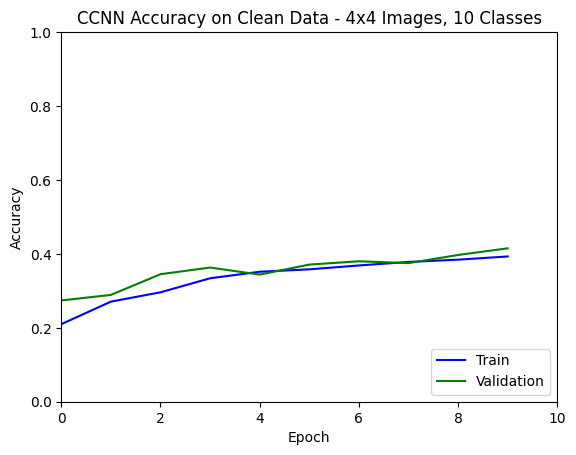

In [19]:
# استفاده از تابع برای رسم دقت
plot_metrics(history_clean_4x4, "accuracy", "CCNN Accuracy on Clean Data - 4x4 Images, 10 Classes")

In [20]:
# ایجاد مدل نویزی برای دیتاست مقیاس‌پذیر
noisy_model_4x4 = create_model_4x4()  # ایجاد مدل 4x4
history_noisy_4x4 = noisy_model_4x4.fit(train_data_noisy_4x4,  # آموزش مدل
                                train_labels_subset,
                                epochs=10,  # تعداد دوره‌های آموزش
                                batch_size=32,  # اندازه دسته
                                validation_data=(test_data_noisy_4x4, test_labels_subset)  # داده‌های اعتبارسنجی
                                )

# ارزیابی بر روی داده‌های آزمایشی نویزی
test_loss_noisy_4x4, test_acc_noisy_4x4 = noisy_model_4x4.evaluate(test_data_noisy_4x4, test_labels_subset, verbose=2)
print(f"Noisy 4x4 Data - Test Accuracy: {test_acc_noisy_4x4:.4f}, Test Loss: {test_loss_noisy_4x4:.4f}")
print(f"Noisy 4x4 Data - Training Accuracy: {history_noisy_4x4.history['accuracy'][-1]:.4f}")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 3, 3, 4)        │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 2, 2, 4)        │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 1, 1, 8)        │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 1, 1, 8)        │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 318 (1.24 KB)

 Trainable params: 318 (1.24 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1477 - loss: 2.3504 - val_accuracy: 0.2030 - val_loss: 2.1966
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1938 - loss: 2.1365 - val_accuracy: 0.2260 - val_loss: 2.0345
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2374 - loss: 2.0121 - val_accuracy: 0.2510 - val_loss: 1.9796
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2559 - loss: 1.9639 - val_accuracy: 0.2590 - val_loss: 1.9401
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2550 - loss: 1.9454 - val_accuracy: 0.2730 - val_loss: 1.9137
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2619 - loss: 1.9164 - val_accuracy: 0.2810 - val_loss: 1.8985
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2761 - loss: 1.9134 - val_accuracy: 0.2870 - val_loss: 1.8870
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2774 - loss: 1.8901 - val_accuracy: 0.

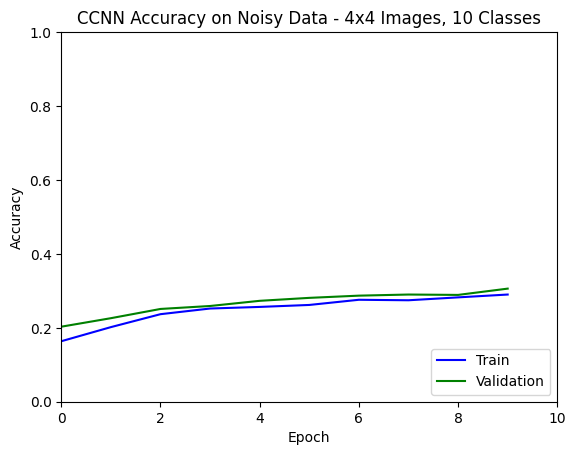

In [21]:
# استفاده از تابع برای رسم دقت
plot_metrics(history_noisy_4x4, "accuracy", "CCNN Accuracy on Noisy Data - 4x4 Images, 10 Classes")

In [22]:
# مقایسه متریک‌های عملکرد دیگر
y_true = test_labels_subset  # برچسب‌های واقعی داده‌های آزمایشی

# پیش‌بینی‌های مدل تمیز
y_pred_clean_4x4 = clean_model_4x4.predict(test_data_clean_4x4)  # پیش‌بینی بر روی داده‌های تمیز
y_pred_clean_4x4 = np.argmax(y_pred_clean_4x4, axis=-1)  # تبدیل احتمال‌ها به ایندکس‌های کلاس

# پیش‌بینی‌های مدل نویزی
y_pred_noisy_4x4 = noisy_model_4x4.predict(test_data_noisy_4x4)  # پیش‌بینی بر روی داده‌های نویزی
y_pred_noisy_4x4 = np.argmax(y_pred_noisy_4x4, axis=-1)  # تبدیل احتمال‌ها به ایندکس‌های کلاس

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [23]:
# متریک‌های داده‌های تمیز
accuracy_clean_4x4 = accuracy_score(y_true, y_pred_clean_4x4)  # محاسبه دقت مدل (نسبت پیش‌بینی‌های صحیح به کل پیش‌بینی‌ها)
precision_clean_4x4 = precision_score(y_true, y_pred_clean_4x4, average='weighted')  # محاسبه دقت (Precision) با وزن‌دهی بر اساس تعداد نمونه‌ها
recall_clean_4x4 = recall_score(y_true, y_pred_clean_4x4, average='weighted')  # محاسبه فراخوان (Recall) با وزن‌دهی بر اساس تعداد نمونه‌ها
f1_clean_4x4 = f1_score(y_true, y_pred_clean_4x4, average='weighted')  # محاسبه نمره F1 با وزن‌دهی بر اساس تعداد نمونه‌ها

# چاپ متریک‌های داده‌های تمیز
print("\nClean Data Metrics:")
print(f"Accuracy: {accuracy_clean_4x4:.4f}") # نمایش دقت
print(f"Precision: {precision_clean_4x4:.4f}") # نمایش دقت (Precision)
print(f"Recall: {recall_clean_4x4:.4f}") # نمایش فراخوان (Recall)
print(f"F1 Score: {f1_clean_4x4:.4f}")  # نمایش نمره F1



Clean Data Metrics:
Accuracy: 0.4150
Precision: 0.3370
Recall: 0.4150
F1 Score: 0.3490


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
# متریک‌های داده‌های نویزی
accuracy_noisy_4x4 = accuracy_score(y_true, y_pred_noisy_4x4)  # محاسبه دقت مدل بر روی داده‌های نویزی (نسبت پیش‌بینی‌های صحیح به کل پیش‌بینی‌ها)
precision_noisy_4x4 = precision_score(y_true, y_pred_noisy_4x4, average='weighted')  # محاسبه دقت (Precision) برای داده‌های نویزی با وزن‌دهی بر اساس تعداد نمونه‌ها
recall_noisy_4x4 = recall_score(y_true, y_pred_noisy_4x4, average='weighted')  # محاسبه فراخوان (Recall) برای داده‌های نویزی با وزن‌دهی
f1_noisy_4x4 = f1_score(y_true, y_pred_noisy_4x4, average='weighted')  # محاسبه نمره F1 برای داده‌های نویزی با وزن‌دهی

print("\nNoisy Data Metrics:")
print(f"Accuracy: {accuracy_noisy_4x4:.4f}")
print(f"Precision: {precision_noisy_4x4:.4f}")
print(f"Recall: {recall_noisy_4x4:.4f}")
print(f"F1 Score: {f1_noisy_4x4:.4f}")


Noisy Data Metrics:
Accuracy: 0.3060
Precision: 0.2868
Recall: 0.3060
F1 Score: 0.2602


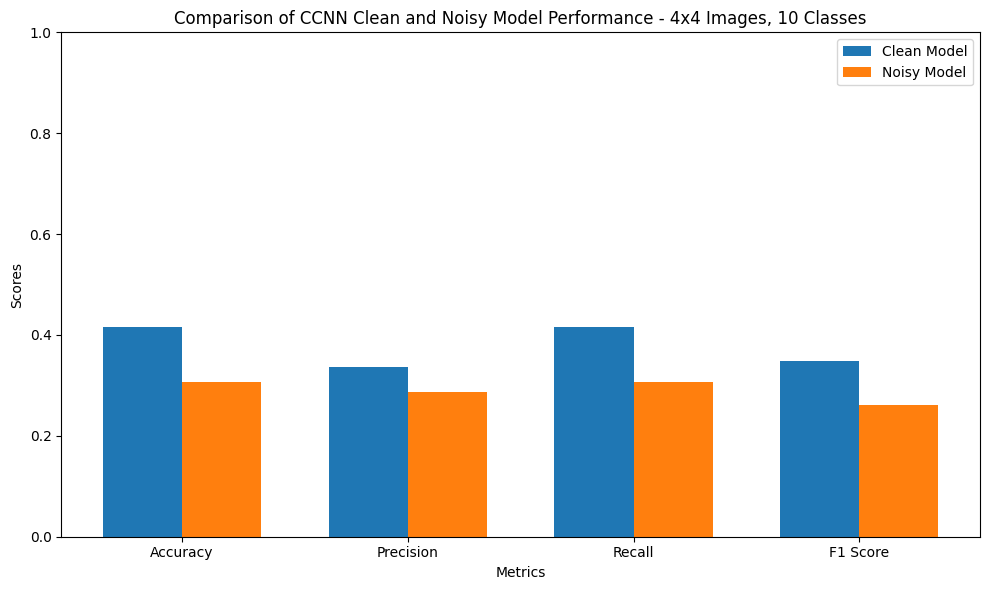

In [25]:
# تعیین متریک‌ها و مقادیر آنها
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']  # لیست متریک‌ها
clean_values = [accuracy_clean_4x4, precision_clean_4x4, recall_clean_4x4, f1_clean_4x4]  # مقادیر متریک‌های داده‌های تمیز
noisy_values = [accuracy_noisy_4x4, precision_noisy_4x4, recall_noisy_4x4, f1_noisy_4x4]  # مقادیر متریک‌های داده‌های نویزی

# تنظیمات برای نمودار
x = np.arange(len(metrics))  # مکان برچسب‌ها بر روی محور x
width = 0.35  # عرض میله‌ها
fig, ax = plt.subplots(figsize=(10, 6))  # ایجاد شکل و محور

# ایجاد میله‌ها برای مدل تمیز و نویزی
rects1 = ax.bar(x - width/2, clean_values, width, label='Clean Model')  # میله‌های مدل تمیز
rects2 = ax.bar(x + width/2, noisy_values, width, label='Noisy Model')  # میله‌های مدل نویزی

# تنظیمات محور و عنوان
ax.set_xlabel('Metrics')  # برچسب محور x
ax.set_ylabel('Scores')  # برچسب محور y
ax.set_title('Comparison of CCNN Clean and Noisy Model Performance - 4x4 Images, 10 Classes')  # عنوان نمودار
ax.set_xticks(x)  # تعیین مکان برچسب‌ها بر روی محور x
ax.set_xticklabels(metrics)  # تعیین برچسب‌های محور x
ax.legend()  # نمایش افسانه (Legend)
ax.set_ylim(0, 1)  # تنظیم محدوده محور y از 0 تا 1
plt.tight_layout()  # بهینه‌سازی چیدمان
plt.show()  # نمایش نمودار



---
The next section provides a different comparison with the binary classification QCNN model, where two classes are selected and again scaled down to 4x4. This model is simplified to have a minimal number of trainable parameters to be a fair comparison with the binary QCNN model.


---




In [26]:
# انتخاب فقط تی‌شرت/بالا (0) و شلوار (1)
classes_to_keep = [0, 1]  # کلاس‌هایی که باید نگه‌داشته شوند
train_filter = np.isin(train_labels, classes_to_keep)  # فیلتر کردن برچسب‌های آموزشی
train_data_bin = train_data_clean[train_filter]  # داده‌های آموزشی فیلتر شده
train_labels_bin = train_labels[train_filter]  # برچسب‌های آموزشی فیلتر شده

test_filter = np.isin(test_labels, classes_to_keep)  # فیلتر کردن برچسب‌های آزمایشی
test_data_bin = test_data_clean[test_filter]  # داده‌های آزمایشی فیلتر شده
test_labels_bin = test_labels[test_filter]  # برچسب‌های آزمایشی فیلتر شده

# نمایش شکل داده‌های آموزشی و آزمایشی باینری
print("شکل داده‌های آموزشی باینری:", train_data_bin.shape)  # نمایش شکل داده‌های آموزشی
print("شکل داده‌های آزمایشی باینری:", test_data_bin.shape)  # نمایش شکل داده‌های آزمایشی

# تبدیل تصاویر این کلاس‌ها به اندازه 4x4 پیکسل
train_binary_4x4 = resize_images_tf(train_data_bin, new_size=(4,4))  # تغییر اندازه تصاویر آموزشی به 4x4
test_binary_4x4 = resize_images_tf(test_data_bin, new_size=(4,4))  # تغییر اندازه تصاویر آزمایشی به 4x4

شکل داده‌های آموزشی باینری: (12000, 28, 28)
شکل داده‌های آزمایشی باینری: (2000, 28, 28)


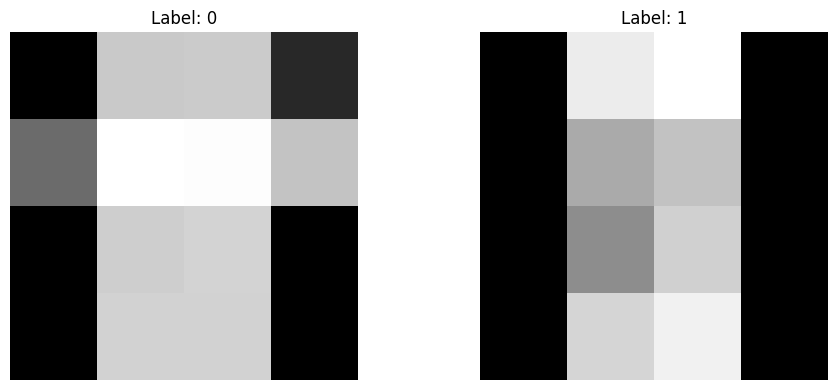

In [27]:
def display_images_bin(images, labels, num_images=3):
    # انتخاب کلاس‌های منحصر به فرد
    selected_classes = np.unique(labels)[:num_images]  # انتخاب کلاس‌های منحصر به فرد تا تعداد num_images

    # لیست‌های خالی برای ذخیره تصاویر و برچسب‌ها
    selected_images = []
    selected_labels = []

    # انتخاب یک تصویر از هر کلاس انتخاب‌شده
    for class_label in selected_classes:
        class_indices = np.where(labels == class_label)[0]  # پیدا کردن ایندکس‌های کلاس
        selected_images.append(images[class_indices[0]])  # انتخاب اولین تصویر از کلاس
        selected_labels.append(labels[class_indices[0]])  # ذخیره برچسب مربوطه

    # تبدیل لیست‌ها به آرایه‌ها
    selected_images = np.array(selected_images)  # تبدیل لیست تصاویر به آرایه
    selected_labels = np.array(selected_labels)  # تبدیل لیست برچسب‌ها به آرایه

    # ایجاد یک شکل برای نمایش تصاویر
    fig, axes = plt.subplots(1, num_images, figsize=(10, 4))  # ایجاد زیرنمودارها

    for i, ax in enumerate(axes):
        ax.imshow(selected_images[i].squeeze(), cmap='gray')  # نمایش تصویر با رنگ خاکستری
        ax.set_title(f'Label: {selected_labels[i]}')  # نمایش برچسب تصویر
        ax.axis('off')  # پنهان کردن محور

    plt.tight_layout()  # بهینه‌سازی چیدمان
    plt.show()  # نمایش شکل

# فراخوانی تابع برای نمایش تصاویر باینری
display_images_bin(train_binary_4x4, train_labels_bin, num_images=2)  # نمایش 2 تصویر از داده‌های آموزشی باینری

In [28]:
# ایجاد یک مدل برای وظایف دسته‌بندی باینری
# مدل بسیار ساده برای داشتن تعداد محدودی از پارامترهای قابل آموزش به منظور مقایسه عادلانه با QCNN
def create_binary_model():
    model = models.Sequential()  # ایجاد یک مدل ترتیبی
    model.add(layers.Conv2D(4, (2,2), activation='relu', input_shape=(4,4,1)))  # لایه کانولوشن با 4 فیلتر و اندازه 2x2
    model.add(layers.Flatten())  # مسطح کردن خروجی از لایه کانولوشن
    model.add(layers.Dense(2))  # لایه Dense با 2 نورون
    model.add(layers.Dense(1))  # لایه Dense نهایی با 1 نورون برای پیش‌بینی باینری

    model.summary()  # نمایش خلاصه مدل

    model.compile(optimizer='adam',  # کامپایل مدل با استفاده از بهینه‌ساز Adam
                  loss=tf.keras.losses.BinaryCrossentropy(),  # استفاده از تابع هزینه باینری کراس‌انتروپی
                  metrics=['accuracy'])  # دقت به عنوان متریک ارزیابی

    return model  # بازگشت مدل

In [29]:
# ایجاد و آموزش مدل باینری
clean_model_bin = create_binary_model()  # ایجاد مدل باینری
history_bin = clean_model_bin.fit(train_binary_4x4,  # آموزش مدل با داده‌های آموزشی باینری
                                  train_labels_bin,  # برچسب‌های آموزشی باینری
                                  epochs=10,  # تعداد دوره‌های آموزش
                                  batch_size=128,  # اندازه دسته
                                  validation_data=(test_binary_4x4, test_labels_bin))  # داده‌های آزمایشی برای اعتبارسنجی

# ارزیابی بر روی داده‌های آزمایشی تمیز
test_loss_clean_bin, test_acc_clean_bin = clean_model_bin.evaluate(test_binary_4x4, test_labels_bin, verbose=2)  # ارزیابی مدل
print(f"Clean Binary Data - Test Accuracy: {test_acc_clean_bin:.4f}, Test Loss: {test_loss_clean_bin:.4f}")  # نمایش دقت و خطای تست
print(f"Clean Binary Data - Training Accuracy: {history_bin.history['accuracy'][-1]:.4f}")  # نمایش دقت نهایی آموزش

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 3, 3, 4)        │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 36)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │            74 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97 (388.00 B)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4955 - loss: 1.2795 - val_accuracy: 0.5735 - val_loss: 0.6838
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6010 - loss: 0.6535 - val_accuracy: 0.6365 - val_loss: 0.6285
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6699 - loss: 0.6107 - val_accuracy: 0.6775 - val_loss: 0.5893
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7107 - loss: 0.5652 - val_accuracy: 0.7190 - val_loss: 0.5513
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7468 - loss: 0.5187 - val_accuracy: 0.7360 - val_loss: 0.5194
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7628 - loss: 0.4871 - val_accuracy: 0.7525 - val_loss: 0.5103
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7762 - loss: 0.4718 - val_accuracy: 0.7620 - val_loss: 0.5058
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7868 - loss: 0.4573 - val_accuracy: 0.7650 - val_loss:

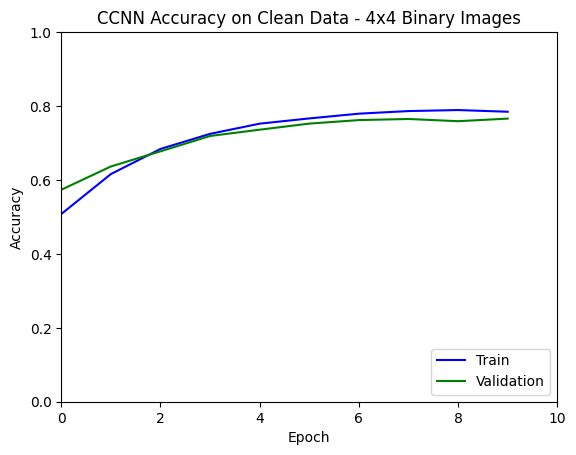

In [30]:
# فراخوانی تابع برای ترسیم دقت
plot_metrics(history_bin, "accuracy", "CCNN Accuracy on Clean Data - 4x4 Binary Images")

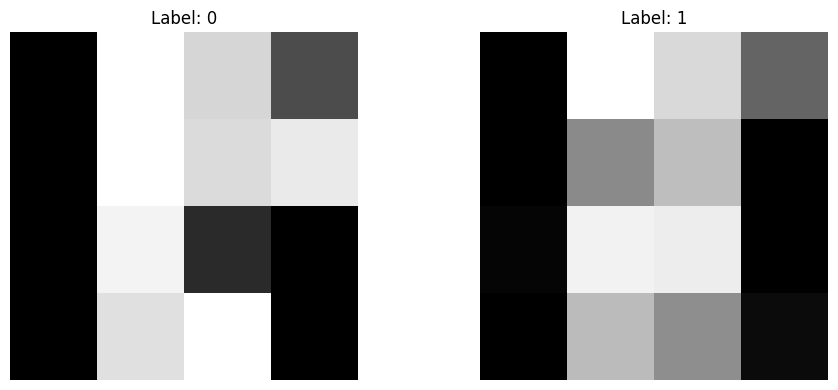

In [31]:
# حالا اضافه کردن نویز به تصاویر باینری
train_data_noisy_bin = add_gaussian_noise(train_binary_4x4, severity=5)  # افزودن نویز گاوسی به داده‌های آموزشی باینری
test_data_noisy_bin = add_gaussian_noise(test_binary_4x4, severity=5)  # افزودن نویز گاوسی به داده‌های آزمایشی باینری

# نمایش تصاویر با نویز
display_images_bin(train_data_noisy_bin, train_labels_bin, num_images=2)  # نمایش 2 تصویر از داده‌های آموزشی باینری که نویز به آنها اضافه شده است

In [32]:
# ایجاد و آموزش مدل باینری با داده‌های نویزی
noisy_model_bin = create_binary_model()  # ایجاد مدل باینری

history_noisy_bin = noisy_model_bin.fit(train_data_noisy_bin,  # آموزش مدل با داده‌های آموزشی باینری نویزی
                                        train_labels_bin,  # برچسب‌های آموزشی باینری
                                        epochs=10,  # تعداد دوره‌های آموزش
                                        batch_size=128,  # اندازه دسته
                                        validation_data=(test_data_noisy_bin, test_labels_bin))  # داده‌های آزمایشی برای اعتبارسنجی

# ارزیابی بر روی داده‌های آزمایشی نویزی
test_loss_noisy_bin, test_acc_noisy_bin = noisy_model_bin.evaluate(test_data_noisy_bin, test_labels_bin, verbose=2)  # ارزیابی مدل
print(f"Noisy Binary Data - Test Accuracy: {test_acc_noisy_bin:.4f}, Test Loss: {test_loss_noisy_bin:.4f}")  # نمایش دقت و خطای تست
print(f"Noisy Binary Data - Training Accuracy: {history_noisy_bin.history['accuracy'][-1]:.4f}")  # نمایش دقت نهایی

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 3, 3, 4)        │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 36)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │            74 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97 (388.00 B)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5451 - loss: 1.3896 - val_accuracy: 0.5435 - val_loss: 0.7945
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5654 - loss: 0.7618 - val_accuracy: 0.5575 - val_loss: 0.7208
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5849 - loss: 0.7003 - val_accuracy: 0.5955 - val_loss: 0.6850
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6226 - loss: 0.6546 - val_accuracy: 0.6160 - val_loss: 0.6609
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6320 - loss: 0.6497 - val_accuracy: 0.6260 - val_loss: 0.6485
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6399 - loss: 0.6392 - val_accuracy: 0.6415 - val_loss: 0.6398
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6498 - loss: 0.6267 - val_accuracy: 0.6485 - val_loss: 0.6333
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6571 - loss: 0.6227 - val_accuracy: 0.6520 - val_loss:

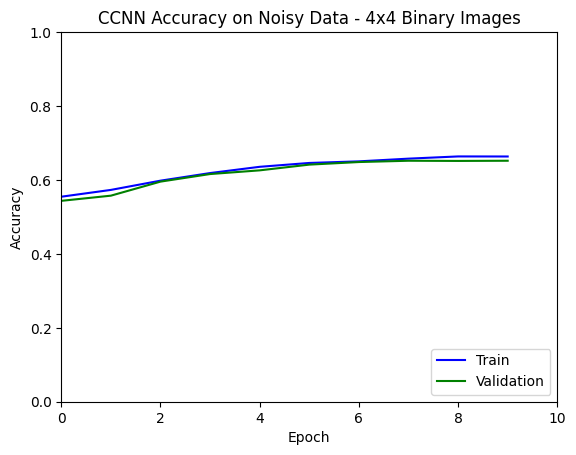

In [33]:
# فراخوانی تابع برای ترسیم دقت
plot_metrics(history_noisy_bin, "accuracy", "CCNN Accuracy on Noisy Data - 4x4 Binary Images")

In [34]:
# مقایسه سایر متریک‌های عملکرد
y_true = test_labels_bin  # برچسب‌های واقعی داده‌های آزمایشی

# پیش‌بینی‌های تمیز
y_pred_clean_bin = clean_model_bin.predict(test_binary_4x4)  # پیش‌بینی مدل بدون نویز بر روی داده‌های آزمایشی تمیز
y_pred_clean_bin = (y_pred_clean_bin > 0.5).astype(int)  # تبدیل احتمالات به کلاس‌های باینری

# پیش‌بینی‌های نویزی
y_pred_noisy_bin = noisy_model_bin.predict(test_data_noisy_bin)  # پیش‌بینی مدل با نویز بر روی داده‌های آزمایشی نویزی
y_pred_noisy_bin = (y_pred_noisy_bin > 0.5).astype(int)  # تبدیل احتمالات به کلاس‌های باینری

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [35]:
# محاسبه متریک‌های عملکرد برای داده‌های تمیز
accuracy_clean_bin = accuracy_score(y_true, y_pred_clean_bin)  # دقت
precision_clean_bin = precision_score(y_true, y_pred_clean_bin, average='weighted')  # دقت مثبت
recall_clean_bin = recall_score(y_true, y_pred_clean_bin, average='weighted')  # یادآوری
f1_clean_bin = f1_score(y_true, y_pred_clean_bin, average='weighted')  # امتیاز F1

# چاپ نتایج متریک‌های تمیز
print("\nClean Data Metrics:")
print(f"Accuracy: {accuracy_clean_bin:.4f}")  # نمایش دقت
print(f"Precision: {precision_clean_bin:.4f}")  # نمایش دقت مثبت
print(f"Recall: {recall_clean_bin:.4f}")  # نمایش یادآوری
print(f"F1 Score: {f1_clean_bin:.4f}")  # نمایش امتیاز F1


Clean Data Metrics:
Accuracy: 0.7660
Precision: 0.7897
Recall: 0.7660
F1 Score: 0.7611


In [36]:
# محاسبه متریک‌های عملکرد برای داده‌های نویزی
accuracy_noisy_bin = accuracy_score(y_true, y_pred_noisy_bin)  # دقت
precision_noisy_bin = precision_score(y_true, y_pred_noisy_bin, average='weighted')  # دقت مثبت
recall_noisy_bin = recall_score(y_true, y_pred_noisy_bin, average='weighted')  # یادآوری
f1_noisy_bin = f1_score(y_true, y_pred_noisy_bin, average='weighted')  # امتیاز F1

# چاپ نتایج متریک‌های نویزی
print("\nNoisy Data Metrics:")
print(f"Accuracy: {accuracy_noisy_bin:.4f}")  # نمایش دقت
print(f"Precision: {precision_noisy_bin:.4f}")  # نمایش دقت مثبت
print(f"Recall: {recall_noisy_bin:.4f}")  # نمایش یادآوری
print(f"F1 Score: {f1_noisy_bin:.4f}")  # نمایش امتیاز F1


Noisy Data Metrics:
Accuracy: 0.6520
Precision: 0.6526
Recall: 0.6520
F1 Score: 0.6516


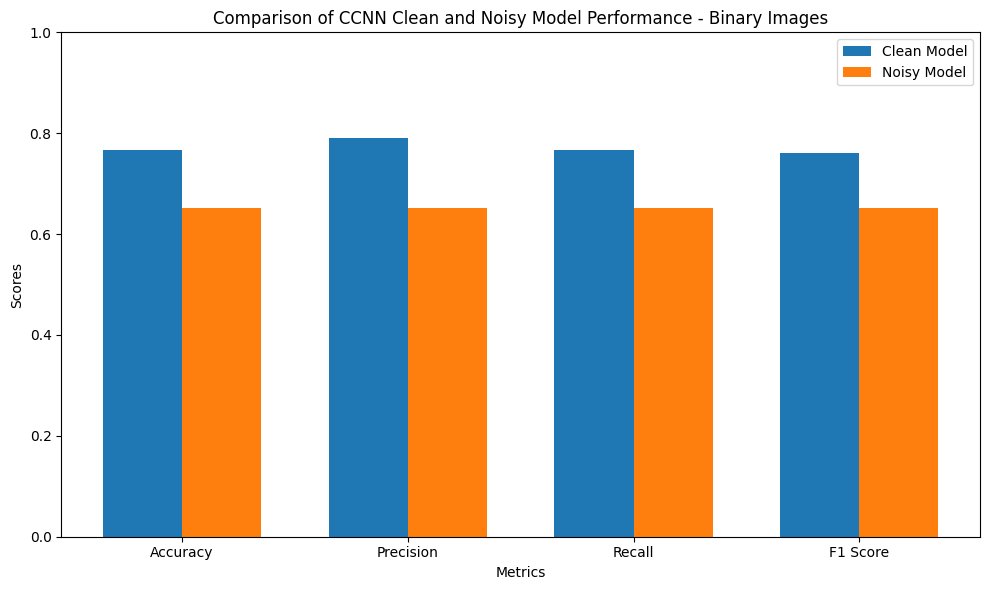

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# تعریف متریک‌ها و مقادیر مربوط به هر مدل
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
clean_values = [accuracy_clean_bin, precision_clean_bin, recall_clean_bin, f1_clean_bin]  # مقادیر مدل تمیز
noisy_values = [accuracy_noisy_bin, precision_noisy_bin, recall_noisy_bin, f1_noisy_bin]  # مقادیر مدل نویزی

# تنظیمات نمودار میله‌ای
x = np.arange(len(metrics))  # موقعیت برچسب‌ها
width = 0.35  # عرض میله‌ها
fig, ax = plt.subplots(figsize=(10, 6))  # ایجاد شکل و محور

# ایجاد میله‌ها برای مدل تمیز و نویزی
rects1 = ax.bar(x - width/2, clean_values, width, label='Clean Model')
rects2 = ax.bar(x + width/2, noisy_values, width, label='Noisy Model')

# تنظیمات محور
ax.set_xlabel('Metrics')  # برچسب محور x
ax.set_ylabel('Scores')  # برچسب محور y
ax.set_title('Comparison of CCNN Clean and Noisy Model Performance - Binary Images')  # عنوان نمودار
ax.set_xticks(x)  # تنظیم موقعیت برچسب‌ها
ax.set_xticklabels(metrics)  # برچسب‌گذاری محور x
ax.legend()  # نمایش افسانه
ax.set_ylim(0, 1)  # محدوده محور y از ۰ تا ۱
plt.tight_layout()  # تنظیمات نهایی
plt.show()  # نمایش نمودار